***

# HCI 2021 Week 5 - Spectral Differential Imaging

*Matthew Kenworthy // Leiden Observatory*
***

Today in [*Questions 5.1*](#part1) *- 5.3* you will determine the spectral type of a faint companion by comparing the flux of the primary star to the flux of the secondary companion. Thereafter in [*Questions 5.4*](#part2) *- 5.8* you will be deriving the Methane Spectral Index (MSI), which is a measure of the amount of methane detected in the companion. 

The data is kindly provided by Dr. Beth Biller from the Royal Observatory Edinburgh.


<div class="alert alert-block alert-warning">
<b>PLEASE 1:</b> You will create .fits files this tutorial: DO <b>NOT</b> UPLOAD A DIRECTORY OR THE FITS IMAGES YOU MAKE, ONLY THE .ipynb NOTEBOOK<br><br>
<b>PLEASE 2:</b> Upload is by chaning the filename to: <b><i>week05_[lastname][herecanputwhatevermessage :)].ipynb</b></i> $\leftarrow$ This saves me 
    $$\# \text{ students}_{\text{not using this format}} \times \text{time}_{\text{it takes you to only upload this notebook in this format}} + \text{time}_{\text{it takes me to delete additional files}} $$<br>
<b>PLEASE 3:</b> Do not forget to add axis labels, title, ect to <b>ALL</b> the plots that you have to make</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> As always, read through the functions defined in the block below, as they may help with the exercises.</div>

Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%config InlineBackend.figure_format = 'retina' 


def box(c,x,y,trim=0):
    """box - chop out a square box from an array c from center (x,y) with width trim"""
    c2 = np.copy(c)
    (nx,ny) = c.shape
    dx = x - trim
    dy = y - trim
    c2 = c[dy:dy+2*trim,dx:dx+2*trim]
    
    return(c2)

def circle_mask(im, xc, yc, rcirc):
    """circle_mask - function that takes the input 2D array 'im' that evaluates the equation 
            (x-x_c)^2 + (y-y_c)^2 < r^2 with circle center coordinates (x_c, y_c) and a radius 'r'
            as input parameters and return a mask array with the same shape as 'im'."""
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    return ( (r < rcirc))

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)


# read in the two data cubes
f1, head = fits.getdata('cube_f1.fits', header=True)
f3a, head = fits.getdata('cube_f3a.fits', header=True)

## Details of the observations
The SDI camera uses two narrowband filters, called `F1` and `F3a`, that measure flux in and out of the methane absorption feature in the H band (1.6 microns).

There are two image cubes, one in the `F1` band and the other in the `F3a` band, each containing four separate images.

`F1` is at 1.575 microns, and `F3a` is at 1.625 microns, with a full width of 0.025 microns. Both filters can be assumed to be 100% transmission inside the filter bandpass and 0% transmission outside the bandpass.

The **Methane Spectral Index (MSI)** is defined as:

$$\text{MSI} = \frac{\text{Mean flux in band F1}}{\text{Mean flux in band F3a}} $$

The primary star is called SCR 1845-6357 has a spectral type M8.5, and the secondary companion appears at a separation of 1.170 arcsec from the primary and at a position angle of 170.20 degrees.

The plate scale of the SDI camera is $0.01725\pm0.00025$ arcsec/pixel.


<div class="alert alert-block alert-success">
<b>Example 5.1:</b> Let us take a look at the observations in the spectral band `F1` </b>
</div>  

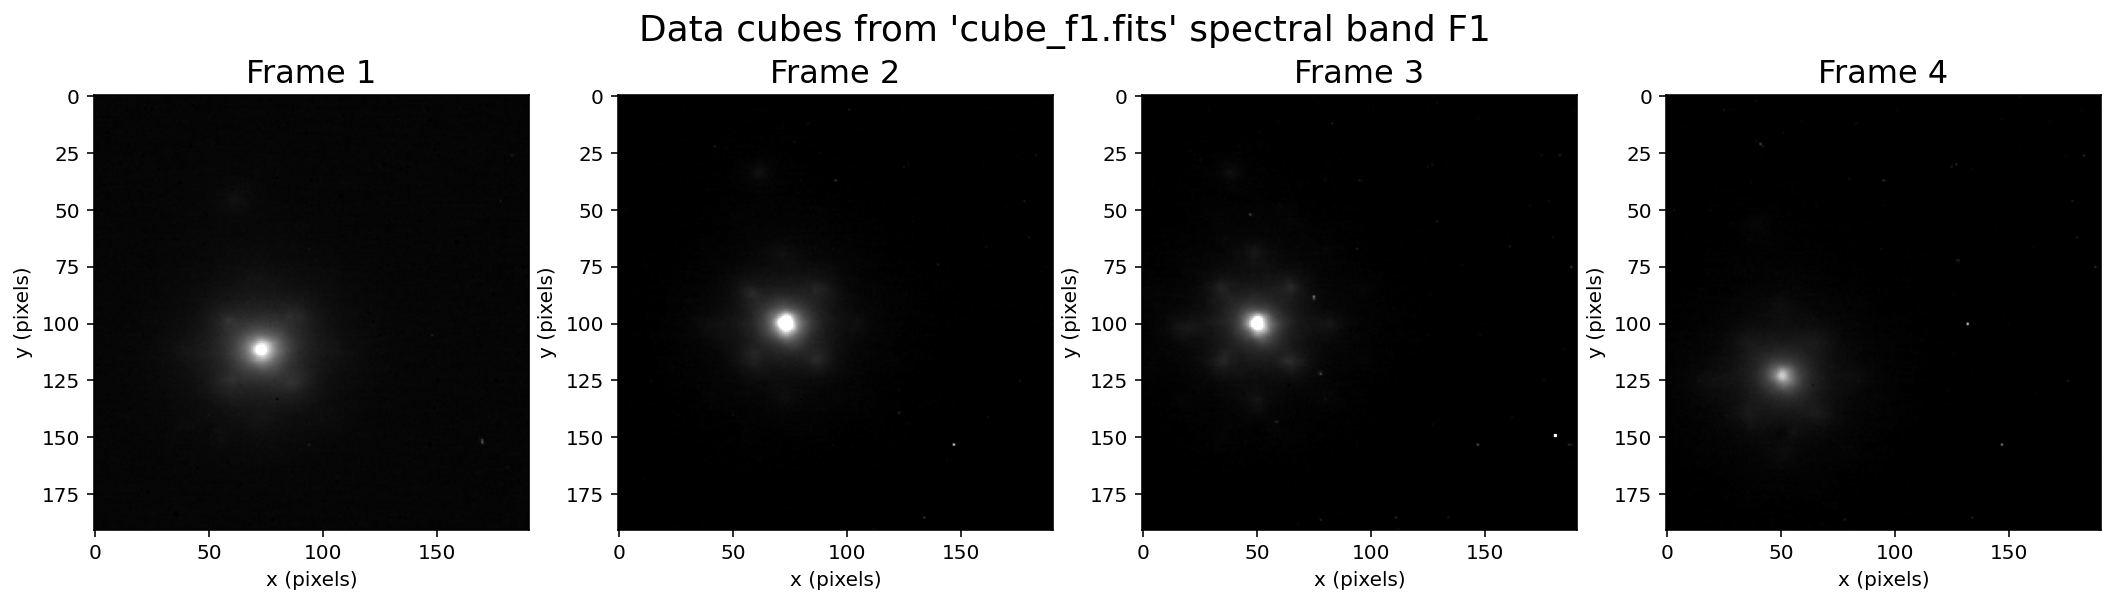

In [2]:
fig, axs = plt.subplots(1,4, figsize=(18,4))   
for idx_a,ax in enumerate(axs.flatten()):
    ax.imshow(f1[idx_a], vmin=0., vmax=1000., cmap='gray')
    ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
    ax.set_title('Frame {}'.format(idx_a+1), fontsize=16) 
fig.suptitle("Data cubes from 'cube_f1.fits' spectral band F1", fontsize=18, y=1.02)

plt.show()


<div class="alert alert-block alert-success">
<b>Example 5.2:</b> We can also use the function <code>box()</code> to make a zoom-in of specific regions in the spectral bands <code>F1</code> and <code>F3a</code>. Look at the several observations and see from the code that the <code>.fits</code> files contain 4 cubes.
</div>  

In [3]:
%run ../week_1/interactive

spectra = [f1,f3a]
title1 = ["cube_f1.fits","cube_f3a.fits"]
title2 = ["F1","F3"]

def interactive_plot_cube(x,y,size,cube):  
    fig, axs = plt.subplots(1,4, figsize=(18,4))   
    
    name1 = title1[cube]
    name2 = title2[cube]
    for idx_a,ax in enumerate(axs.flatten()):
        ax.imshow(box(spectra[cube][idx_a],x,y,size), vmin=0., vmax=1000., cmap='gray')
        ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
        ax.set_title('Frame {}'.format(idx_a+1), fontsize=18)      
    fig.suptitle("Data cubes from '{}' spectral band {}".format(name1,name2), fontsize=18, y=1.02)
    return    

interactive_plot = interactive(interactive_plot_cube, x=(70,130), y=(70,130), size=(40,70,10), cube=widgets.Dropdown( options=[('F1', 0), ('F3a', 1)],value=0, description='Spectral band:'))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot


interactive(children=(IntSlider(value=100, description='x', max=130, min=70), IntSlider(value=100, description…

## Measuring MSI from a Spectral Library
<a id='part1'></a>

Spectra of M, L and T stars in the near-infrared (M and L Dwarf Near-Infrared Standards) have been collected at the SpeX Prism Spectral Libraries:

http://pono.ucsd.edu/~adam/browndwarfs/spexprism/library.html

You should download the `All sources` Zip archive and expand all the spectra into a local directory, and then continue to keep the page open and look at the detailed web pages.


---
<span style="  font-size:2em; color: SteelBlue;">Question 5.1</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Create a Figure containing the spectrum of the primary star that reveals the spectral bands**

1. **Given the spectral type of the primary star, find a spectrum with the same spectral type. Download it in ascii format. This will give you a `.txt` file. Open it using `spec_star = ascii.read('<spectrum_file_here>.txt')` and plot it using `ax.errorbar()`.**


<div class="alert alert-block alert-info">
<b>Tip 1:</b> Look at the first few lines of each of the spectra files... </div>

2. **Make the wavelength go from 1.0 to 2.0 microns. Normalise the flux from 0.0 to 1.0.**
* **Add a red rectangle to show the wavelength range of the F1 filter and a green rectangle for the wavelength range of the F3a filter. Make sure they have the correct bandwidth. Make sure that `alpha=0.5` so you can see the spectrum of the star.**

<div class="alert alert-block alert-info">
<b>Tip 2:</b> Go read about <code>matplotlib.patches</code> and <code>patches.Rectangle()</code> using Google... </div>

---


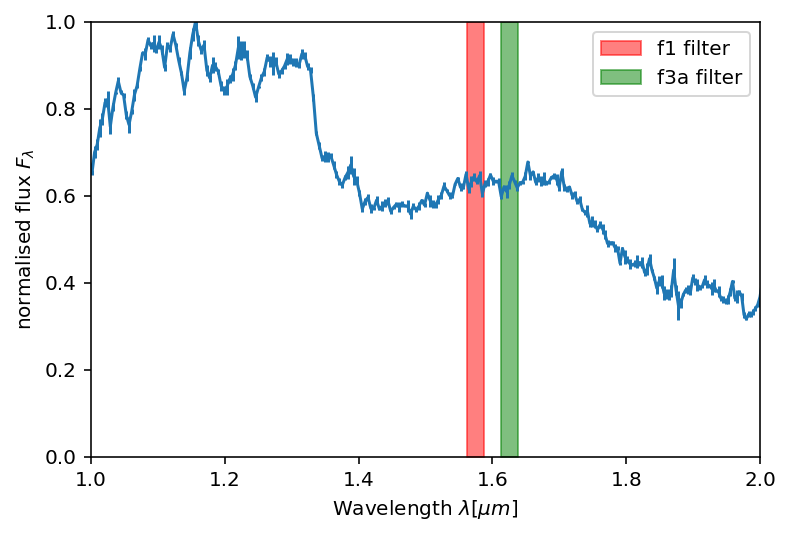

In [4]:
from astropy.io import ascii
#spec_star = ascii.read('<spectrum_file_here>.txt')

# Q1 code here
import os
import numpy as np
pool = []
for root, dirs, files in os.walk("../all/", topdown=False):
    for i,name in enumerate(files):
        fname = os.path.join(root, name)
        
        try:
            with open(fname) as file:
                lines = [next(file) for x in range(10)]

            holder = '# Near infrared spectral type:'
            for s in lines:
                if holder in s:
                    if "M8.5" in s.split(":")[1]:
                        pool.append(i) 
                       
                        
                        if i == 20:
                            data = np.genfromtxt(fname)
                            wl = data[:,0]
                            flux = data[:,1]/data[:,1].max()
                            err = data[:,2]/data[:,1].max()
                            bw = .025
                            f1_loc = 1.575
                            f3a_loc = 1.625
                            f1_x = np.linspace(f1_loc-bw/2,f1_loc+bw/2,100)
                            f3a_x = np.linspace(f3a_loc-bw/2,f3a_loc+bw/2,100)
                            #print(fname)
                            plt.errorbar(x=wl,y=flux,yerr=err,ls='-')
                            plt.fill_between(f1_x,0,1,color='red',alpha=.5,label='f1 filter')
                            plt.fill_between(f3a_x,0,1,color='green',alpha=.5,label='f3a filter')
                            plt.xlim([1,2])
                            plt.ylim([0,1])
                            plt.xlabel('Wavelength $\lambda[\mu m]$')
                            plt.ylabel('normalised flux $F_{\lambda}$')
                            plt.legend()
                            plt.show()
           
        except UnicodeDecodeError:
            pass
                
        
# Q1 end of code


---
<span style="  font-size:2em; color: SteelBlue;">Question 5.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Write a function `flux_filter(wlen, flux, wlen0, dwlen)` that calculates the mean flux transmitted through a boxcar filter with central wavelength `wlen0` and filter width `dwlen` and the spectrum is input as `(wlen, flux)`**

In [5]:
def flux_filter(wlen, flux, wlen0, dwlen):
    """flux_filter - returns the mean flux transmitted through a boxcar filter with central 
            wavelength wlen0, filter width dwlen and flux input is (wlen, flux)""" 
    # Q2 code here 
    flux_filter = flux[(wlen<=wlen0+dwlen/2)*(wlen>=wlen0-dwlen/2)]
    return flux_filter.mean()
    # Q2 end of code

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.3</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Calculate the MSI, `star_msi`, for this M8.5 star, and display it to 2 decimal places.**


In [6]:
# Q3 answer here
mean_f1 = flux_filter(wl,flux,f1_loc,bw)
mean_f3a = flux_filter(wl,flux,f3a_loc,bw)
star_msi = mean_f1/mean_f3a
print("The MSI of the star is: ","%.2f"%star_msi)
# Q3 end of answer

# print('Methane spectral index of the star is ...'.format(star_msi))


The MSI of the star is:  1.01


<a id='part2'></a>

## Determining the MSI of the secondary companion

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.4</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Measure the flux of the primary star and secondary companion using apertures with a diameter of 0.5 arcseconds.**

<div class="alert alert-block alert-info">
<b>Hint 1:</b> Calculate the diameter of the aperture in pixels and examine the image cubes in ds9. <br>Investigate the options of the Frame toolbar to switch between all the different images that are stored in the cube </div>

1. **Make two arrays holding the measured x and y positions of the primary star.** 
* **Use an offset to determine the position of the secondary companion.**
* **Make a loop to go over each of the 4 images, and write out the flux ratio between the primary star and the secondary companion.**

<div class="alert alert-block alert-info">
<b>Hint 2:</b> Is the background flux surrounding the stars at a level of zero counts? <br>If not, you should measure the background flux and subtract it off the image...</div>

---


In [7]:
%run ds9 cube_f1.fits

In [8]:
# Q4 code here
def companion_loc(x0,y0,dist=1.170,deg=170.20):
    """
    Input the primary star's location, and calculate its companion's
    location.
    - (x0,y0): primary star's coordinate
    """
    plate_scale = .01725 #arcsec/pixel
    dist_pixel = dist/plate_scale
    angle = deg/180*np.pi
    dx = dist_pixel*np.sin(angle)
    dy = dist_pixel*np.cos(angle)
    x = x0-dx
    y = y0+dy
    
    return (x,y)

def get_flux_ratio(c,x0,y0,x1,y1,D):
    """
    Get the flux ratio between the primary star and companion.
    -(x0,y0): star's location.
    -(x1,y1): companion's location.
    -D: aperture diameter.
    """
    msk1 = circle_mask(c,150,50,D/2)
    msk2 = circle_mask(c,int(x0),int(y0),D/2)
    msk3 = circle_mask(c,int(x1),int(y1),D/2)
    #plt.imshow(msk2+msk3+msk1,origin='lower')
    #plt.plot(x1,y1,marker='o')
    #plt.plot(x0,y0,marker='*')
    #plt.show()
    bg_flux = c[msk1==1].mean()
    star_flux = c[msk2==1].mean()-bg_flux
    companion_flux = c[msk3==1].mean()-bg_flux
    
    return star_flux/companion_flux
    
xcen = np.array([73.5,74,50.5,51])
ycen = np.array([112.5,101,101.5,124])
ratio_f1 = np.zeros_like(xcen)
D = .5 # in units of arcsec
plate_scale  = .01725 #arcsec/pixel
D_pix = D/plate_scale
xcomp = np.zeros_like(xcen)
ycomp = np.zeros_like(ycen)
print("The aperture diameter is {:.0f}".format(D_pix))
print("-"*35,"f1","-"*35)
for i in range(4):
    x_comp,y_comp = companion_loc(xcen[i],ycen[i])
    xcomp[i] = x_comp
    ycomp[i] = y_comp
    #print(x_comp,y_comp)
    ratio_f1[i] = get_flux_ratio(f1[i],xcen[i],ycen[i],x_comp,y_comp,D_pix)
print("The flux ratios between the primary star and the secondary companion are: \n",ratio_f1)
print("-"*35,"f3a","-"*35)
xcen = np.array([74.5,75,51.5,52])
ycen = np.array([115,103.5,103.5,127])
ratio_f3a = np.zeros_like(xcen)
for i in range(4):
    x_comp,y_comp = companion_loc(xcen[i],ycen[i])
    ratio_f3a[i] = get_flux_ratio(f3a[i],xcen[i],ycen[i],x_comp,y_comp,D_pix)
print("The flux ratios between the primary star and the secondary companion are: \n",ratio_f3a)
# Q4 end of code    

The aperture diameter is 29
----------------------------------- f1 -----------------------------------
The flux ratios between the primary star and the secondary companion are: 
 [24.11906815 25.66988945 22.65777969 20.94844818]
----------------------------------- f3a -----------------------------------
The flux ratios between the primary star and the secondary companion are: 
 [55.49184418 63.91059494 44.86837006 37.73942566]


---
<span style="  font-size:2em; color: SteelBlue;">Question 5.5</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**SANITY CHECK on Question 5.4**

**Make sure you have got your coordinates right by cutting out a `box(x,y,20)` of the image and displaying it. The star/companion should be in the middle of the box. Have a look at the code below to make a 2x2 array of images, or simply make 4 images from the `F1` cube showing that you have the primary star location correct**

It should look something like:

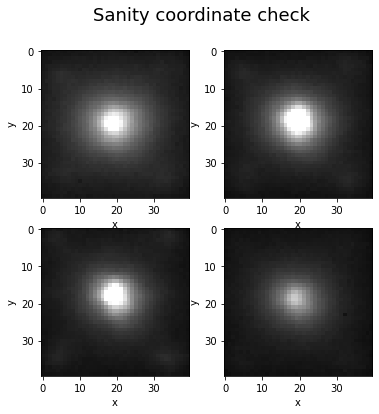

---


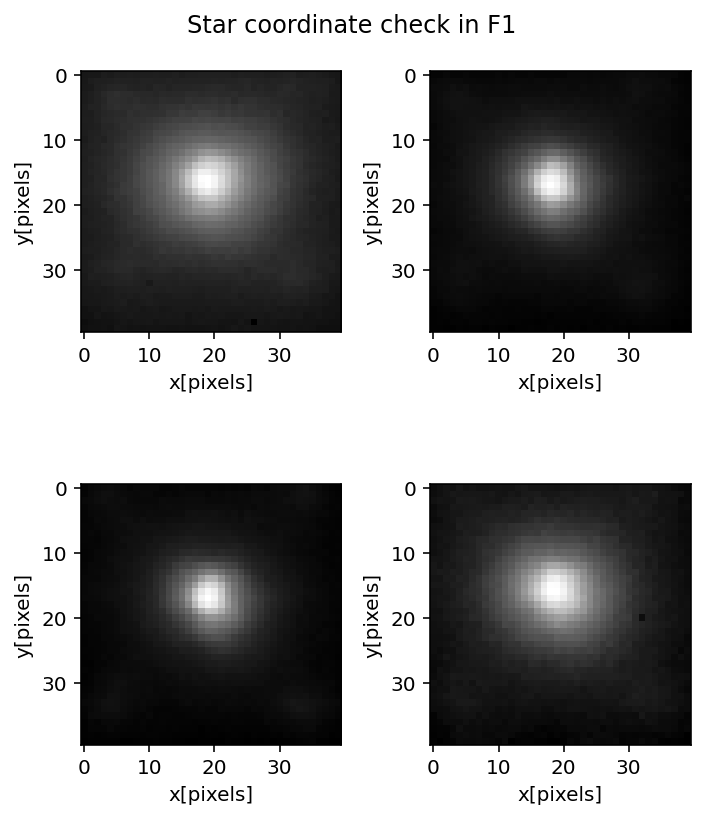

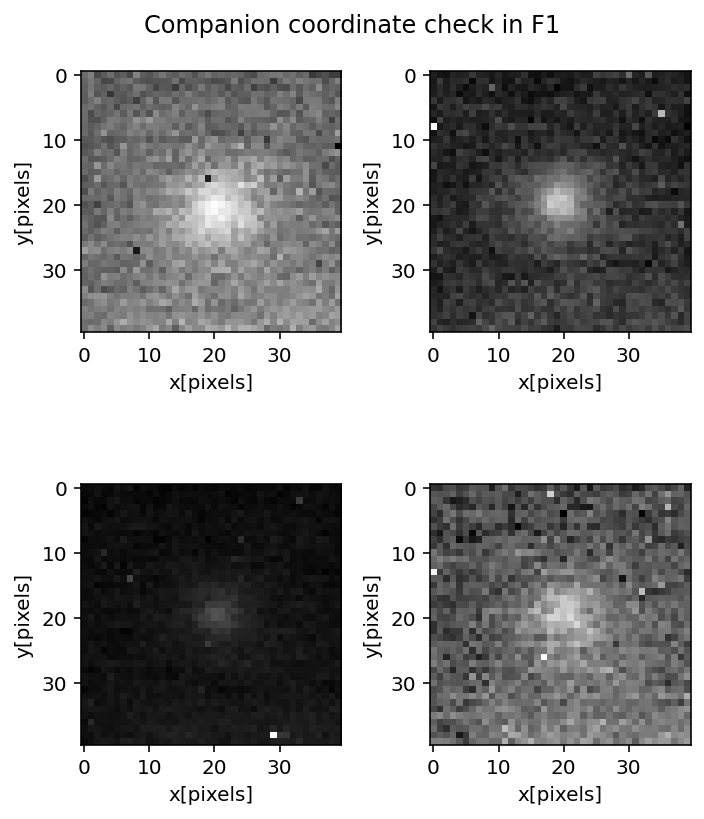

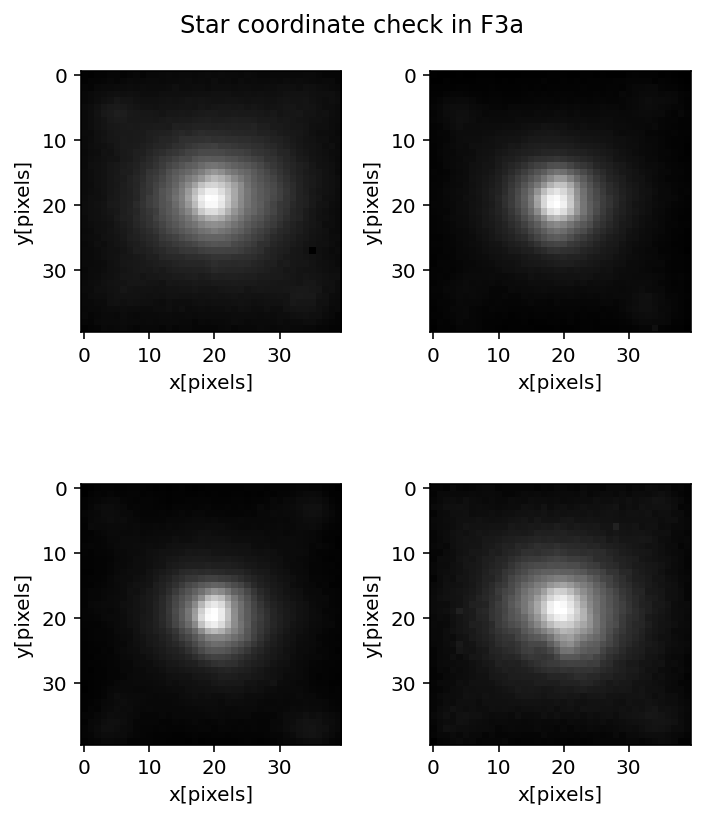

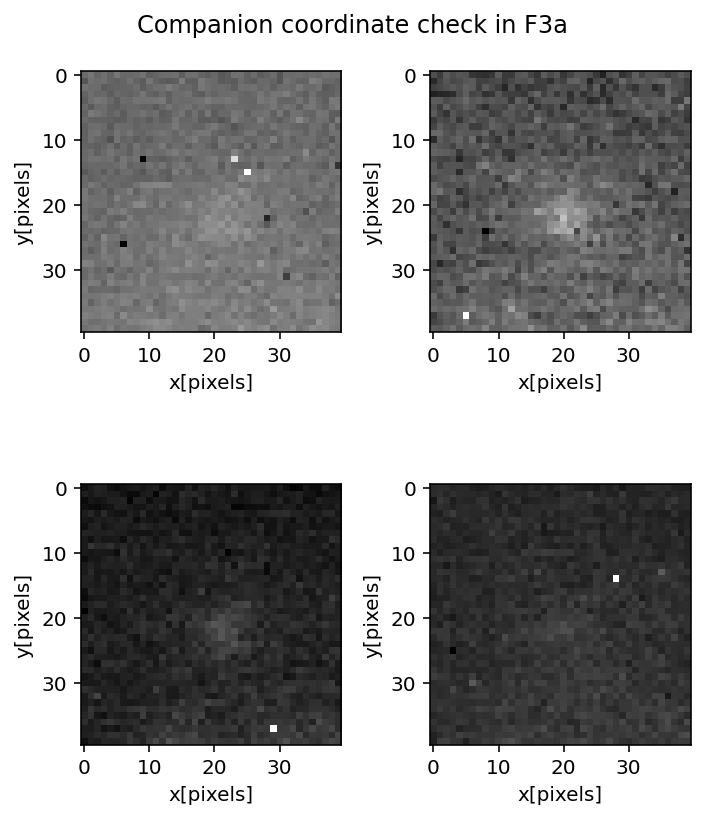

In [9]:
# Q5 answer here
fig = plt.figure(figsize=(5,6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    c = box(f1[i],int(xcen[i]),int(ycen[i]),20)
    ax.imshow(c,cmap='Greys_r')
    ax.set_xlabel('x[pixels]')
    ax.set_ylabel('y[pixels]')
plt.tight_layout()  
fig.suptitle("Star coordinate check in F1")
plt.show()

fig = plt.figure(figsize=(5,6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    c = box(f1[i],int(xcomp[i]),int(ycomp[i]),20)
    ax.imshow(c,cmap='Greys_r')
    ax.set_xlabel('x[pixels]')
    ax.set_ylabel('y[pixels]')
plt.tight_layout()  
fig.suptitle("Companion coordinate check in F1")
plt.show()

fig = plt.figure(figsize=(5,6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    c = box(f3a[i],int(xcen[i]),int(ycen[i]),20)
    ax.imshow(c,cmap='Greys_r')
    ax.set_xlabel('x[pixels]')
    ax.set_ylabel('y[pixels]')
plt.tight_layout()  
fig.suptitle("Star coordinate check in F3a")
plt.show()

fig = plt.figure(figsize=(5,6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    c = box(f3a[i],int(xcomp[i]),int(ycomp[i]),20)
    ax.imshow(c,cmap='Greys_r')
    ax.set_xlabel('x[pixels]')
    ax.set_ylabel('y[pixels]')
plt.tight_layout()  
fig.suptitle("Companion coordinate check in F3a")
plt.show()
# Q5 end of answer 

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Now you have 4 measurements of flux ratio at F1 and at F3a for the primary star compared to the secondary companion. Calculate the MSI for the secondary companion and estimate an error using `np.mean()` and `np.std()`. You should obtain one value for the MSI and one error.**

---


In [10]:
# Q6 answer here

msi_mean = np.mean(ratio_f3a/ratio_f1*star_msi)
msi_err = np.std(ratio_f3a/ratio_f1*star_msi)

print('Methane spectral index of the companion is {:.2f} +- {:.2f}'.format(msi_mean, msi_err))


# Q6 end of answer



Methane spectral index of the companion is 2.17 +- 0.27


## Comapring your result to Biller et al. (2006)
The measured methane spectral index in Biller et al. (2006) is $2.7 \pm 0.1$

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Is there a significant difference between your MSI and that in the paper? If YES, why? Are your propagated errors larger than Biller's measurements? If YES, why?**

---



In [11]:
# Q7 answer here
print("1. There is a ～20% difference between my MSI and that in the paper.\n")
print("Answer: Data were sky-subtracted, flat-fielded, and bad-pixel masked for Biller's measurements. The data frames were aligned and median combined using IRAF afterwards. As for my result, no such post-processing was done.\n")
print("2. Yes, the propagated errors are larger than Biller's measurements.\n")
print("Answer: Because Biller's frames were reduced, and bad pixel-removed, which leads to a smaller deviation from the mean when computing the msi ratio.")
# Q7 end of answer

1. There is a ～20% difference between my MSI and that in the paper.

Answer: Data were sky-subtracted, flat-fielded, and bad-pixel masked for Biller's measurements. The data frames were aligned and median combined using IRAF afterwards. As for my result, no such post-processing was done.

2. Yes, the propagated errors are larger than Biller's measurements.

Answer: Because Biller's frames were reduced, and bad pixel-removed, which leads to a smaller deviation from the mean when computing the msi ratio.


## Determining the spectral type of the secondary companion

---
<span style="  font-size:2em; color: SteelBlue;">Question 5.8</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Construct a plot showing spectral type along the x-axis with methane spectral index on the y-axis.**

1. **Go to the SPeX webpage, and download the L dwarf and T dwarf spectral libraries.**
* **Pick a star from every** ***Near IR spectral type*** **subtype from L6 to T8 (i.e. L6, L7, L8, L9, T0, T1...)
* **Calculate the Methane Spectral Index, and plot it below.**

<div class="alert alert-block alert-info">
<b>Tip:</b> It is easier to have a number represent the spectra type, i.e. 6 = L6, 8 = L8, 10 = T0....). </div>


4. **Overplot your measured Methane Spectral Index for the secondary companion and determine what spectral type the companion is.**
* **Add legend, axes lables ect..**
* **Take the errors from your 4 measurements of MSI to estimate by eye an error in spectral type.**


---


In [12]:
# Q8 answer here
import os

def get_type(tar):
    if "+/-" in tar:
        return tar.split("+/-")[0]
    elif "pec" in tar:
        return tar.split("pec")[0]
    elif "(pec)" in tar:
        return tar.split("(pec)")[0]
    else:
        return tar
    
spectral_type = np.array(['L6','L7','L8','L9','T0','T1','T2','T3','T4','T5','T6','T7','T8'])
stars_msi = np.zeros(len(spectral_type))
for root, dirs, files in os.walk("./dwarfs/", topdown=False):
    for i,name in enumerate(files):
        fname = os.path.join(root, name)
        #print(fname)
        try:
            with open(fname) as file:
                lines = [next(file) for x in range(10)]

            holder = '# Near infrared spectral type:'
            for s in lines:
                if holder in s:
                    tar = s.split(":")[1][2:]
                    
                    
                    for num,s_type in enumerate(spectral_type):
                        if s.split(":")[1][1:3] in s_type:
                            
                            data = np.genfromtxt(fname)
                            wl = data[:,0]
                            flux = data[:,1]/data[:,1].max()
                            err = data[:,2]/data[:,1].max()
                            bw = .025
                            f1_loc = 1.575
                            f3a_loc = 1.625
                            f1_x = np.linspace(f1_loc-bw/2,f1_loc+bw/2,100)
                            f3a_x = np.linspace(f3a_loc-bw/2,f3a_loc+bw/2,100)
                            mean_f1 = flux_filter(wl,flux,f1_loc,bw)
                            mean_f3a = flux_filter(wl,flux,f3a_loc,bw)
                            if stars_msi[num] == 0:
                                #print("stype",s.split(":")[1])
                                stars_msi[num] = mean_f1/mean_f3a
                                #print(stars_msi[num])
                            else: 
                                pass
                            
        except UnicodeDecodeError:
            pass
   
# Q8 end of answer

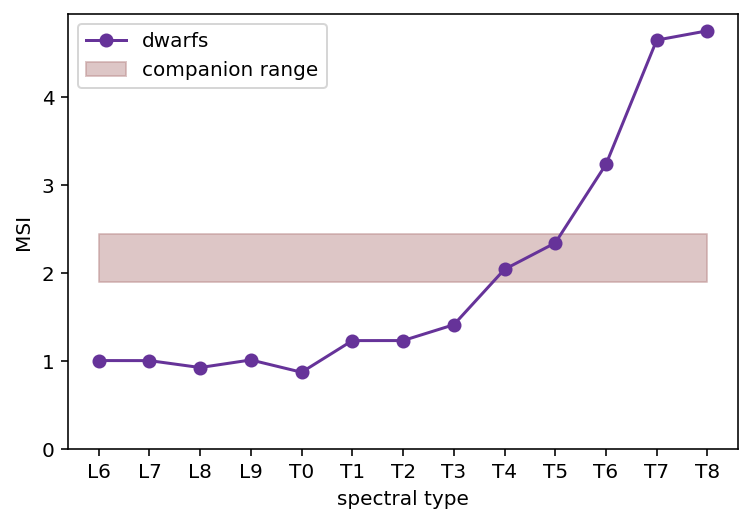

In [13]:
plt.plot(spectral_type,stars_msi,'o-',color='rebeccapurple',label='dwarfs')
plt.xlabel('spectral type')
plt.ylabel('MSI')
#plt.axhline(y=msi_mean-msi_err)
#plt.axhline(y=msi_mean+msi_err)
plt.ylim([0,None])
plt.fill_between(spectral_type,msi_mean-msi_err,msi_mean+msi_err,color='rosybrown',alpha=.5,label='companion range')
plt.legend()
plt.show()

In [14]:
print("The companion is likely to be a star of spectral type T4-T5.")

The companion is likely to be a star of spectral type T4-T5


---
<span style="  font-size:2em; color: SteelBlue;">Question 5.99</span> <span style="  font-size:1em; color: SteelBlue;">
(0 points): </span>

**During coding I always find it nice to have some background music. What is your favourite song that you can recomment?**


---

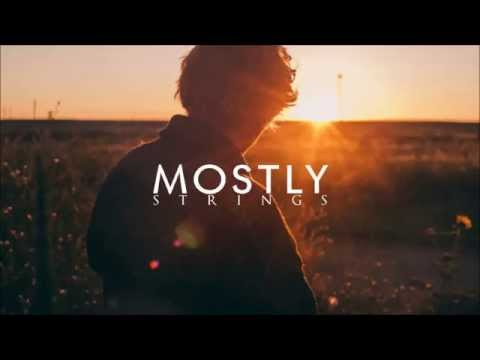

In [15]:
from IPython.display import YouTubeVideo
youtube_video = YouTubeVideo('VL6inz4WPhQ')
display(youtube_video)


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it!</div>


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


Number of hours taken for this practicum: ~ 6 hours.
